In [2]:
#matthew berning, 2021

import os
import sys
import math
import random

import PIL
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

# Dataset Structure  
  
## We are interested in how the classifier performs over sucessive seasons -we have 2 to work with: 2019 and 2020  
  
so, we will train our model on 2019 data (train/test sets) and then evaluate on 2019 data and 2020 data (validation sets)

## Awned cultivars outnumber awnless cultivars considerably..

so, we need to over-sample the under represented class


In [5]:
#the 'key file' is our master dataset-structure document, it has all the file names and the respective info
key_file = pd.read_csv("/pless_nfs/home/matthewrberning/multi-year-cult-class/data/KEY_AM-PANEL_20210414.csv")

#plot_name == cultivar
#plot_id == unique plot number

key_file.head()

/pless_nfs/home/matthewrberning/miniconda3/envs/data_exp38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,plot_id,plot_name,yday,date,dir,file,PCTHEAD,AWNS,GRWT,GRYLD,LOI,MOIST,PTHT,SPKLNG,SPLSPK,SPNAREA,TESTWT,TGW
0,18ASH3-F-0100,EVEREST,128,2018-05-08,20180508_18ASH_AM3_X5R_6m_-60_video,DJI_A01733_C002_20180508_000123_1264_0824_1775...,NaN,AWNED,1216.0,2.68,NaN,14.7,67.5,NaN,NaN,NaN,71.2,NaN
1,18ASH3-F-0100,EVEREST,128,2018-05-08,20180508_18ASH_AM3_X5R_6m_-60_video,DJI_A01733_C002_20180508_000124_1776_0824_2287...,NaN,AWNED,1216.0,2.68,NaN,14.7,67.5,NaN,NaN,NaN,71.2,NaN
2,18ASH3-F-0100,EVEREST,128,2018-05-08,20180508_18ASH_AM3_X5R_6m_-60_video,DJI_A01733_C002_20180508_000123_2800_0824_3311...,NaN,AWNED,1216.0,2.68,NaN,14.7,67.5,NaN,NaN,NaN,71.2,NaN
3,18ASH3-F-0100,EVEREST,128,2018-05-08,20180508_18ASH_AM3_X5R_6m_-60_video,DJI_A01733_C002_20180508_000124_0240_0824_0751...,NaN,AWNED,1216.0,2.68,NaN,14.7,67.5,NaN,NaN,NaN,71.2,NaN
4,18ASH3-F-0100,EVEREST,128,2018-05-08,20180508_18ASH_AM3_X5R_6m_-60_video,DJI_A01733_C002_20180508_000121_2800_0824_3311...,NaN,AWNED,1216.0,2.68,NaN,14.7,67.5,NaN,NaN,NaN,71.2,NaN


### the original data (.tif files) from KSU is located inside the Globus depository

data_path: "/pless_nfs/home/matthewrberning/globus/data/KSU/images_2021_02_01/images/X5R/processed/"

we can see when we list/sort/count the dirs that there are collection events for 2018, 2019, and 2020 data

we can also see that there are more collection events for 2018 and 2019 then there are for 2020


### during the initial cultivar classification project setup the 2019 and 2020 .tif images (512x512x4) were saved as center-cropped .jpg (300x300x3)

data_path: "/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/"

this was done to increase I/O speeds while still saving some space for data augmentation (the model expects 224x224x3)

but, for safety's sake we should still validate that the data is where we think it is


In [8]:
data_path = "/pless_nfs/home/matthewrberning/globus/data/KSU/images_2021_02_01/images/X5R/processed/"
dir_lst = os.listdir(data_path)
dir_lst.sort()

#view the dirs
dir_lst

['20180508_18ASH_AM3_X5R_6m_-60_video',
 '20180510_18ASH_AM3_X5R_6m_-60_video',
 '20180514_18ASH_AM3_X5R_6m_-60_video',
 '20180515_18ASH_AM3_X5R_6m_-60_video',
 '20180516_18ASH_AM3_X5R_6m_-60_video',
 '20180517_18ASH_AM3_X5R_6m_-60_video',
 '20180518_18ASH_AM3_X5R_6m_-60_video',
 '20180521_18ASH_AM3_X5R_6m_-60_video',
 '20180522_18ASH_AM3_X5R_6m_-60_video',
 '20180523_18ASH_AM3_X5R_6m_-60_video',
 '20180525_18ASH_AM3_X5R_6m_-60_video',
 '20180528_18ASH_AM3_X5R_3m_-60_video',
 '20180529_18ASH_AM3_X5R_4m_-60_video',
 '20180531_18ASH_AM3_X5R_4m_-70_video',
 '20180601_18ASH_AM3_X5R_4m_-70_video',
 '20180613_18ASH_AM3_X5R_5m_-70_video',
 '20190506_19RF_AM_X5R_5m_-60_video_Flight1',
 '20190508_19RF_AM_X5R_5m_-60_video_Flight1',
 '20190510_19RF_AM_X5R_5m_-60_video_Flight1',
 '20190512_19RF_AM_X5R_5m_-60_video_Flight1',
 '20190513_19RF_AM_X5R_5m_-60_video_Flight1',
 '20190515_19RF_AM_X5R_5m_-60_video_Flight1',
 '20190516_19RF_AM_X5R_5m_-60_video_Flight1',
 '20190517_19RF_AM_X5R_5m_-60_video_Fl

### (we're working with just 2019 and 2020 for now)

In [7]:
# empty lists to collect 2019/2020 
lst_2019_dirs = []
lst_2020_dirs = []

# for each directory
for d in dir_lst:
    # check if the directory is from 2019
    if '2019' in d:
        #assemble list of 2019 dirs for training set
        lst_2019_dirs.append(d)
    
    # check if it is from 2020
    elif '2020' in d:
        # assemble list of 2020 dirs for test set
        lst_2020_dirs.append(d)


print("2019 flights: ",len(lst_2019_dirs))       
print("2020 flights: ",len(lst_2020_dirs))  

2019 flights:  16
2020 flights:  12


In [48]:
#count and display the number of images in each directory
previous_year = 2018 #var to help seperate out years

year_count = 0 #var to track total images in a year

dir_count = 0

for d in dir_lst:
    
    #var to track the number of images
    count = 0 
    
    #var to print the year
    if '2018' in d:
        year = 2018
    elif '2019' in d:
        year = 2019
    else:
        year = 2020
        
    #loop through list of objects inside the specified directory
    for obj in os.listdir(os.path.join(data_path, d)):

        #if it's a tif add to count
        if obj.endswith('.tif'):
            count+=1
            
    #align numbers for sanity
    count = str(count).rjust(7)
    
    #seperate out years
    if year != previous_year:
        #report the total and average
        print(f"-       TOTAL: {str(year_count).rjust(7)}   dirs: {dir_count} [ average: {math.ceil(year_count/dir_count)} ]")
        year_count = 0 #reset the year count
        
        dir_count = 0 #reset the dir count
    
    #reset the current previous year
    previous_year = year
    
    print(f"{year} | images: {count}   dir: {d}")
    
    #add the count for that dir to the total for the year
    year_count+=int(count)
    
    #add to the count of directories for that year
    dir_count+=1

#report
print(f"-       TOTAL: {str(year_count).rjust(7)}   dirs: {dir_count} [ average: {math.ceil(year_count/dir_count)} ]")

2018 | images:   55783   dir: 20180508_18ASH_AM3_X5R_6m_-60_video
2018 | images:   27230   dir: 20180510_18ASH_AM3_X5R_6m_-60_video
2018 | images:   60368   dir: 20180514_18ASH_AM3_X5R_6m_-60_video
2018 | images:   60326   dir: 20180515_18ASH_AM3_X5R_6m_-60_video
2018 | images:   97461   dir: 20180516_18ASH_AM3_X5R_6m_-60_video
2018 | images:   55503   dir: 20180517_18ASH_AM3_X5R_6m_-60_video
2018 | images:   60368   dir: 20180518_18ASH_AM3_X5R_6m_-60_video
2018 | images:   50512   dir: 20180521_18ASH_AM3_X5R_6m_-60_video
2018 | images:   56861   dir: 20180522_18ASH_AM3_X5R_6m_-60_video
2018 | images:   88319   dir: 20180523_18ASH_AM3_X5R_6m_-60_video
2018 | images:   55258   dir: 20180525_18ASH_AM3_X5R_6m_-60_video
2018 | images:   66682   dir: 20180528_18ASH_AM3_X5R_3m_-60_video
2018 | images:   32116   dir: 20180529_18ASH_AM3_X5R_4m_-60_video
2018 | images:  106197   dir: 20180531_18ASH_AM3_X5R_4m_-70_video
2018 | images:   64596   dir: 20180601_18ASH_AM3_X5R_4m_-70_video
2018 | ima

### now we'll isolate the image file names from 2019 and 2020 in the three places they're located
1 - the key file  
2 - the globus depository (.tif)  
3 - the dir with cropped images (.jpg)  


In [67]:
#path to cropped data
data_path = "/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/"

#collect all the file names if they are images (end in .jpg)
cropped_filenames_list = []

path_lst = os.listdir(data_path)

for obj in path_lst:
    
    #check if it's the image type we're looking for
    if obj.endswith(".jpg"):
        cropped_filenames_list.append(obj)
        
print(len(cropped_filenames_list), " image file names found")        
print("example: ", cropped_filenames_list[0])

2227833  image file names found
example:  20190522_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A00417_C024_20190522_000319_3312_0824_3823_1336_19RKY00116.jpg


In [60]:
#path to globus data
data_path = "/pless_nfs/home/matthewrberning/globus/data/KSU/images_2021_02_01/images/X5R/processed/"

#use previously found 2019 and 2020 dir names (lst_2019_dirs and lst_2020_dirs)
list_of_dirs = lst_2019_dirs + lst_2020_dirs

#empty list for collecting image paths
tif_filenames_list = []


#loop through list of dirs
for _dir in tqdm(list_of_dirs):

    #loop through list of objects inside the specified directory
    for obj in os.listdir(os.path.join(data_path, _dir)):

        #it's probably an image, add it to the list
        if obj.endswith('.tif'):
            
            #modify the filename to match those in jpg dir for easier comparison
            tif_filenames_list.append(f"{_dir}_{obj}")

print(len(tif_filenames_list), " image file names (plus dir name) found")        
print("example: ", tif_filenames_list[0])

100%|██████████| 28/28 [00:02<00:00, 12.23it/s]

2360441  image file names (plus dir name) found
example:  20190506_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A06276_C005_20190506_000722_1776_0824_2287_1336_19RKY00623.tif


In [71]:
#collect from the key_file
key_file_filenames_list = []

#copy the relevant data into a new df to collect from the key_file
#(remember this doesn't work with mutable objects in a df)
key_file_filenames_df = key_file[['dir', 'file']].copy(deep=True) 

#create a funt to combine path info into the dataframe too 
def create_filename(row, path):
    
    #concat the info in the rows
    filename = row['dir'] + '_' + row['file']

    return filename

#apply the above helper function with lambda (expect a 'SettingWithCopyWarning')
key_file_filenames_df['img_loc'] = key_file_filenames_df.apply (lambda row: create_filename(row, path), axis=1)

#turn the whole collumn (2018, 2019, and 2020 names included) into a list
key_file_filenames_lst_all = key_file_filenames_df['img_loc'].tolist()

#get only 2019 and 2020 filenames
for name in key_file_filenames_lst_all:
    if '2019' in name or '2020' in name:
#         if name.endswith(".tif")
        key_file_filenames_list.append(name)

print(len(key_file_filenames_lst_all), " total image filenames (2018,2019, 2020)")
print(len(key_file_filenames_list), " image file names (plus dir name) gotten from key_file (only 2019 and 2020)")        
print("example: ", key_file_filenames_list[0])

3410105  total image filenames
2360448  image file names (plus dir name) gotten from key_file
example:  20190506_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A06276_C028_20190506_000040_1776_0824_2287_1336_19RKY0-F-0100.tif


In [73]:
#check for files in key_file but not in the globus directory 
list(set(tif_filenames_list) - set(key_file_filenames_list))

[]

In [112]:
#check for files in globus directories but not in the key_file
list(set(key_file_filenames_list) - set(tif_filenames_list))

['20190517_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A06276_C010_20190517_000962_2288_0824_2799_1336_19RKY00494.tif.filepart',
 '20190519_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A06276_C001_20190519_000541_0240_0824_0751_1336_19RKY00715.tif.filepart',
 '20190519_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A06276_C001_20190519_000540_2800_0824_3311_1336_19RKY00715.tif.filepart',
 '20190517_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A06276_C016_20190517_000643_0240_0824_0751_1336_19RKY00329.tif.filepart',
 '20190519_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A06276_C001_20190519_000540_2288_0824_2799_1336_19RKY00715.tif.filepart',
 '20190517_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A06276_C016_20190517_000643_2288_0824_2799_1336_19RKY00329.tif.filepart',
 '20190519_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A06276_C001_20190519_000541_1264_0824_1775_1336_19RKY00715.tif.filepart']

### so.. we can see that there are some partial files created during the Globus transfer/download 

but all the files specified in the key file are present in the globus depository

### the files in the cropped (.jpg) directory are all 2019 and 2020 images without 'fill plots' and NaN's
we can verify this by first counting the total size of the 2019 and 2020 df's once the 
fill plots and NaN's have been removed, then we can also compare the filenames in the df's 
with the ones actually in the dir

In [86]:
#rewrite the names of the files to end in '.tif' to make the comparison easier
cropped_filenames_list_tiff = []

for i in cropped_filenames_list:
    cropped_filenames_list_tiff.append(i.split('.')[0] + '.tif')

#verify change
print(cropped_filenames_list[0])
print(cropped_filenames_list_tiff[0])

#check for files in key_file but not in the cropped directory (fill plots and Nan's)
print("\nfile names in key_file but not in cropped directory: ",len(list(set(key_file_filenames_list) - set(cropped_filenames_list_tiff))))

20190522_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A00417_C024_20190522_000319_3312_0824_3823_1336_19RKY00116.jpg
20190522_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A00417_C024_20190522_000319_3312_0824_3823_1336_19RKY00116.tif

file names in key_file but not in cropped directory:  132615


### now we can look at the sizes of the dataset in terms of the key file
we can also see how the cutlivars and awned vs awnless plots change 

In [88]:
#remove 'fill plots' i.e. plots just used for spacing out the relevant cultivars
key_file_NoFillPlots = key_file[~key_file['plot_id'].str.contains('F')].copy(deep=True) 
print(len(key_file_NoFillPlots), "  -total entries in Key File WITHOUT FILL PLOTS")

#remove plots where the cultivar was not reccorded (remember plot_name == cultivar)
key_file_NoFillPlots_no_NaNs = key_file_NoFillPlots[key_file_NoFillPlots['plot_name'].notna()]
print(len(key_file_NoFillPlots_no_NaNs),"  -total entries in Key File WITHOUT FILL PLOTS and WITHOUT NaN's")

#examine the number of cultivars after each reduction
# cultivars1 = key_file_NoFillPlots['plot_name'].unique()
# print(f"\n{len(cultivars1)}  -Total CULTIVARS in Key File without Fill Plots")

# cultivars2 = key_file_NoFillPlots_no_NaNs['plot_name'].unique()
# print(f"{len(cultivars2)}  -Total CULTIVARS in Key File without Fill Plots and without NaN's")

3210556   -total entries in Key File WITHOUT FILL PLOTS
3200182   -total entries in Key File WITHOUT FILL PLOTS and WITHOUT NaN's


In [ ]:
#subdivide keyfile into dataframes for 2020 and 2019
key_2020_data = key_file_NoFillPlots_no_NaNs[(key_file_NoFillPlots_no_NaNs['dir'].isin(lst_2020_dirs))]
key_2019_data = key_file_NoFillPlots_no_NaNs[(key_file_NoFillPlots_no_NaNs['dir'].isin(lst_2019_dirs))]

In [93]:
print(f"{str(len(key_2020_data) + len(key_2019_data)).rjust(7)}  -total 2019 and 2020 data points") 
#note: the above num is the same as cropped_filename_list!

print(f"{str(len(key_2019_data)).rjust(7)}  -total 2019 data points (train/test)")
print(f"{str(len(key_2020_data)).rjust(7)}  -total 2020 data points (validate)")

#determine how many cultivars are present in each dataset
key_2020_data_cultivars =  key_2020_data['plot_name'].unique()
key_2019_data_cultivars = key_2019_data['plot_name'].unique()

print(f"\n{len(key_2019_data_cultivars)}  -Total CULTIVARS in key_2019_data")
print(f"{len(key_2020_data_cultivars)}  -Total CULTIVARS in key_2020_data")

2227833  -total 2019 and 2020 data points
1379769  -total 2019 data points (train/test)
 848064  -total 2020 data points (validate)

340  -Total CULTIVARS in key_2019_data
340  -Total CULTIVARS in key_2020_data


In [169]:
def create_filename_jpg(row, path):
    
    #concat the info in the rows
    filename = row['dir'] + '_' + row['file'].split('.')[0] + '.jpg'

    return filename

def compare_dir_with_df(dir_filenames_list, df1, df2):
       
    #collect the relevant columns from the dfs (copy so as to not mess with the originals)
    filenames_df1 = df1[['dir', 'file']].copy(deep=True) 
    filenames_df2 = df2[['dir', 'file']].copy(deep=True) 
    
    #use the helper function create_filename_jpg() as input to a lambda to make new columns 
    filenames_df1['img_loc'] = filenames_df1.apply (lambda row: create_filename_jpg(row, path), axis=1)
    filenames_df2['img_loc'] = filenames_df2.apply (lambda row: create_filename_jpg(row, path), axis=1)
    
    #put the resultant columns into lists
    df1_filenames_list = filenames_df1['img_loc'].tolist()
    df2_filenames_list = filenames_df2['img_loc'].tolist()
    
    #add the two lists together
    df_filenames_list = df1_filenames_list + df2_filenames_list
    
    #report output
    print(f"filenames in dir but not in df: {list(set(df_filenames_list) - set(dir_filenames_list))}")
    print(f"filenames in df but not in dir: {list(set(dir_filenames_list) - set(df_filenames_list))}")

In [170]:
#all the files for 2019 and 2020 that should be there are there! 
compare_dir_with_df(cropped_filenames_list, key_2020_data, key_2019_data)

filenames in dir but not in df: []
filenames in df but not in dir: []


### Save the 2020 and 2019 key files as csv's so they persist

then create the training, validation, and testing sets from the 2019 data! 

In [ ]:
#store to disk
key_2019_data.to_csv('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_key.csv', index=False)
key_2020_data.to_csv('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2020_key.csv', index=False)

#### Using the 2019 key file make a train and validation set

In [49]:
#read from disk
key_2019 = pd.read_csv('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_key.csv')

In [50]:
#add a column for the image location
#helper function to combine path and appropriate file extention
def create_filename(row, path):
    
    #concat the info in the rows
    filename = path + row['dir'] + '_' + row['file'].split('.')[0] + '.jpg'

    return filename

path = "/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/"

#apply the above helper function with lambda (expect a 'SettingWithCopyWarning')
key_2019['img_loc'] = key_2019.apply (lambda row: create_filename(row, path), axis=1)

In [51]:
key_2019.head()

,plot_id,plot_name,yday,date,dir,file,PCTHEAD,AWNS,GRWT,GRYLD,LOI,MOIST,PTHT,SPKLNG,SPLSPK,SPNAREA,TESTWT,TGW,img_loc
0,19RKY00001,2180,126,2019-05-06,20190506_19RF_AM_X5R_5m_-60_video_Flight1,DJI_A06276_C028_20190506_000063_2800_0824_3311...,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/pless_nfs/home/matthewrberning/multi-year-cul...
1,19RKY00001,2180,126,2019-05-06,20190506_19RF_AM_X5R_5m_-60_video_Flight1,DJI_A06276_C028_20190506_000074_0240_0824_0751...,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/pless_nfs/home/matthewrberning/multi-year-cul...
2,19RKY00001,2180,126,2019-05-06,20190506_19RF_AM_X5R_5m_-60_video_Flight1,DJI_A06276_C028_20190506_000074_3312_0824_3823...,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/pless_nfs/home/matthewrberning/multi-year-cul...
3,19RKY00001,2180,126,2019-05-06,20190506_19RF_AM_X5R_5m_-60_video_Flight1,DJI_A06276_C028_20190506_000068_1776_0824_2287...,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/pless_nfs/home/matthewrberning/multi-year-cul...
4,19RKY00001,2180,126,2019-05-06,20190506_19RF_AM_X5R_5m_-60_video_Flight1,DJI_A06276_C028_20190506_000075_1264_0824_1775...,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/pless_nfs/home/matthewrberning/multi-year-cul...


In [52]:
key_2019.iloc(0)[0]['img_loc']

'/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/20190506_19RF_AM_X5R_5m_-60_video_Flight1_DJI_A06276_C028_20190506_000063_2800_0824_3311_1336_19RKY00001.jpg'

In [53]:
#drop all of the rows where there was not yet any data to describe the awn status 
#i.e. (too early in the season for awns/heads)
key_2019_no_nan = key_2019.dropna(subset=['AWNS'])

print(f"there are {len(key_2019)} rows in the 2019 dataset, after removing NaN's {len(key_2019_no_nan)} remain...")

there are 1379769 rows in the 2019 dataset, after removing NaN's 593950 remain...


In [54]:
#inspect the awned vs awnless cultivars
awned_cultivars = key_2019_no_nan[(key_2019_no_nan['AWNS'] == 'AWNED')]
awned_cultivars_set = set(awned_cultivars["plot_name"].to_list()) #setify to get unique values

awnless_cultivars = key_2019_no_nan[(key_2019_no_nan['AWNS'] == 'AWNLESS')]
awnless_cultivars_set = set(awnless_cultivars["plot_name"].to_list())

print(f"total cultivars:   {str(len(awnless_cultivars_set) + len(awned_cultivars_set)).rjust(4)}")
print(f"awnless cultivars: {str(len(awnless_cultivars_set)).rjust(4)}")
print(f"awned cultivars:   {str(len(awned_cultivars_set)).rjust(4)}")

total cultivars:    338
awnless cultivars:   16
awned cultivars:    322


In [55]:
#now find just the unique plots that hold the awnless cultivars
awnless_plots = key_2019_no_nan[(key_2019_no_nan['AWNS'] == 'AWNLESS')]

awnless_plots_set = set(awnless_plots["plot_id"].to_list())
print("unique awnless plots: ",len(awnless_plots_set))

unique awnless plots:  32


In [56]:
#for good measure inspect the relationship between the awnless cultivars and the plots
for cultivar in awnless_cultivars_set:
    print(" cultivar: ",cultivar)
    cultivars_rows = key_2019_no_nan[(key_2019_no_nan['plot_name'] == cultivar)]
    
    plot_id_list = cultivars_rows['plot_id'].unique()
    
    print("plot ID's: ",plot_id_list)
    
    rows1 = cultivars_rows[(cultivars_rows['plot_id'] == plot_id_list[0])]
    rows2 = cultivars_rows[(cultivars_rows['plot_id'] == plot_id_list[1])]
    
    print("imgs/plot:   ",len(rows1), "        ",len(rows2),"\n")

 cultivar:  TX03A0148
plot ID's:  ['19RKY00330' '19RKY00380']
imgs/plot:    1666          686 

 cultivar:  ARROW
plot ID's:  ['19RKY00222' '19RKY00563']
imgs/plot:    1239          1190 

 cultivar:  LONGHORN
plot ID's:  ['19RKY00134' '19RKY00540']
imgs/plot:    903          854 

 cultivar:  OK1068002
plot ID's:  ['19RKY00189' '19RKY00387']
imgs/plot:    987          1008 

 cultivar:  PIONEER-25R39
plot ID's:  ['19RKY00195' '19RKY00375']
imgs/plot:    826          1015 

 cultivar:  OK10119
plot ID's:  ['19RKY00313' '19RKY00709']
imgs/plot:    469          560 

 cultivar:  PETE
plot ID's:  ['19RKY00316' '19RKY00529']
imgs/plot:    1554          1400 

 cultivar:  ERNIE
plot ID's:  ['19RKY00067' '19RKY00629']
imgs/plot:    910          1295 

 cultivar:  TAM-401
plot ID's:  ['19RKY00174' '19RKY00508']
imgs/plot:    1232          1281 

 cultivar:  DELIVER
plot ID's:  ['19RKY00182' '19RKY00496']
imgs/plot:    1197          1050 

 cultivar:  TAM-109
plot ID's:  ['19RKY00011' '19RKY00

In [57]:
random.seed(27)

#collect a training set of 257 cultivars (out of the 322 awned cultivars)
awned_cultivars_train = random.sample(awned_cultivars_set, 257)

awned_cultivars_val_test_temp = [item for item in awned_cultivars_set if item not in awned_cultivars_train]

#seperate out the testing set of cultivars (19)
awned_cultivars_test = random.sample(awned_cultivars_val_test_temp, 19)

#and the validation set of cultivars (all remaining: 46)
awned_cultivars_val = [item for item in awned_cultivars_val_test_temp if item not in awned_cultivars_test]

print("train: ",len(awned_cultivars_train))
print("-temp: ",len(awned_cultivars_val_test_temp))
print("val:   ",len(awned_cultivars_val))
print("test:  ",len(awned_cultivars_test))

train:  257
-temp:  65
val:    46
test:   19


In [60]:
li = [2,2.3,2.4]
l_s = set(li)
len(l_s)

3

In [61]:
#randomly select 12 awnless cultivars to put in the training set 
#(we're going to hold out 1 of the plots from 2 of the cultivars for the validation set)
awnless_cultivars_train = random.sample(awnless_cultivars_set, 12)

#put the other 4 cultivars in the test set
awnless_cultivars_test = [item for item in awnless_cultivars_set if item not in awnless_cultivars_train]

#these will be the two cultivars to segregate out the plots
awnless_cultivars_val = random.sample(awnless_cultivars_train, 2)

#create a list to hold the plots that I will be putting in the validation set (and also back into the training set)
awnless_plots_val_list = []
awnless_plots_train_list = []

#how many plots from each cultivar will we take?
num_plots = 1

for cultivar in awnless_cultivars_val:
    #remove that cultivar from the list
    awnless_cultivars_train.remove(cultivar)
    
    #collect all the rows from the key df that correspond to those cultivars
    awnless_val_plots_temp_df = key_2019_no_nan[(key_2019_no_nan['plot_name'] == cultivar)]
    
    #find the unique plot ID's across the subset 
    awnless_val_plot_ids = set(awnless_test_plots_temp_df["plot_id"].to_list())
    
    #listify
    awnless_val_plot_ids_list = list(awnless_val_plot_ids)
    
    #record
    print(f"cultivar '{cultivar}' has {len(awnless_val_plot_ids_list)} plots:\n{awnless_val_plot_ids_list}")
    
    #randomly select one of the ID's to go into the validation set
    into_val = random.sample(awnless_val_plot_ids_list, num_plots)
    
    #assign all other ID's to go back into the training set
    back_to_train = [item for item in awnless_val_plot_ids_list if item not in into_val]
    
    print(f"to validation set: {into_val}")
    print(f"to training set:   {back_to_train}\n")
    
    #add the plots to their respective lists
    awnless_plots_val_list.append(into_val[0])
    awnless_plots_train_list.append(back_to_train[0])

#record
print("train set cultivars:        ",len(awnless_cultivars_train))
print("validation set cultivars:   ",len(awnless_cultivars_val)) #only used to facilitate segregation
print("test set cultivars:         ",len(awnless_cultivars_test),"\n")

print("val plots:      ",awnless_plots_val_list)
print("train plots:    ",awnless_plots_train_list)
print("test cultivars: ", awnless_cultivars_test)

cultivar 'HG-9' has 2 plots:
['19RKY00629', '19RKY00067']
to validation set: ['19RKY00067']
to training set:   ['19RKY00629']

cultivar 'LOCKETT' has 2 plots:
['19RKY00629', '19RKY00067']
to validation set: ['19RKY00067']
to training set:   ['19RKY00629']

train set cultivars:         10
validation set cultivars:    2
test set cultivars:          4 

val plots:       ['19RKY00067', '19RKY00067']
train plots:     ['19RKY00629', '19RKY00629']
test cultivars:  ['PIONEER-25R39', 'PETE', 'TAM-109', 'OK02405']


In [62]:
train_set_2019 = key_2019_no_nan[key_2019_no_nan['plot_id'].isin(awnless_plots_train_list) | key_2019_no_nan['plot_id'].isin(awnless_cultivars_train) | key_2019_no_nan['plot_name'].isin(awned_cultivars_train)]

In [63]:
val_set_2019 = key_2019_no_nan[key_2019_no_nan['plot_id'].isin(awnless_plots_val_list) | key_2019_no_nan['plot_name'].isin(awned_cultivars_val)]

In [64]:
test_set_2019 = key_2019_no_nan[key_2019_no_nan['plot_name'].isin(awnless_cultivars_test) | key_2019_no_nan['plot_name'].isin(awned_cultivars_test)]

In [69]:
print(f'''
Images in each subset:
train instances:      {len(train_set_2019)}
validation instances:  {len(val_set_2019)}
test instances:        {len(test_set_2019)}
''')


Images in each subset:
train instances:      450023
validation instances:  79436
test instances:        39991



In [70]:
awns_dict = {"AWNED": 0, "AWNLESS": 1}

train_set_2019['awn_label'] = train_set_2019["AWNS"].map(awns_dict)
test_set_2019['awn_label'] = test_set_2019["AWNS"].map(awns_dict)
val_set_2019['awn_label'] = val_set_2019["AWNS"].map(awns_dict)

train = train_set_2019[['img_loc', 'awn_label']].copy()
val = val_set_2019[['img_loc', 'awn_label']].copy()
test = test_set_2019[['img_loc', 'awn_label']].copy()

<ipython-input-70-2732a38b0d58>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_2019['awn_label'] = train_set_2019["AWNS"].map(awns_dict)
<ipython-input-70-2732a38b0d58>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_2019['awn_label'] = test_set_2019["AWNS"].map(awns_dict)
<ipython-input-70-2732a38b0d58>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [71]:
#save to csv
train.to_csv('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns.csv', index=False)
val.to_csv('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_val_awns.csv', index=False)
test.to_csv('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns.csv', index=False)

### the training dataset is imballanced -so we need to oversample the minority class! 
the awnless class (labled '1') is the minority class

In [87]:
#load the training set from csv
train_df = pd.read_csv('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns.csv')
train_df.tail()

,img_loc,awn_label
450018,/pless_nfs/home/matthewrberning/multi-year-cul...,0
450019,/pless_nfs/home/matthewrberning/multi-year-cul...,0
450020,/pless_nfs/home/matthewrberning/multi-year-cul...,0
450021,/pless_nfs/home/matthewrberning/multi-year-cul...,0
450022,/pless_nfs/home/matthewrberning/multi-year-cul...,0


In [88]:
#verify the dataset is imballanced
label_gb = train_df.groupby("awn_label")["img_loc"].nunique()
label_gb

awn_label
0    448728
1      1295
Name: img_loc, dtype: int64

In [89]:
#verify the dataset is imballanced
label_vc = train_df['awn_label'].value_counts()
label_vc

0    448728
1      1295
Name: awn_label, dtype: int64

In [90]:
#collect the number of rows with the awnless label '1'
awnless_num = label_vc.loc[1]
print("awnless: ", awnless_num)

awnless:  1295


In [91]:
#collect the number of rows with the awned label '0'
awned_num = label_vc.loc[0]
print("awned: ", awned_num)

awned:  448728


In [92]:
#collect anly the awnless rows 
awnless_df = train_df[train_df["awn_label"] == 1]

#verify we have the right number
awnless_df['awn_label'].value_counts()

1    1295
Name: awn_label, dtype: int64

In [93]:
#put all the image locations for all the awnless datapoints into a list
awnless_img_locs = awnless_df["img_loc"].to_list()

num_awn_img_pths = len(awnless_img_locs)

print("number of image paths: ",num_awn_img_pths)

number of image paths:  1295


In [95]:
#until the number of images(paths) of each class are equal randomly assign
#a path from the original list of awnless paths to the new upsampled list
new_sampled_img_pths = []
labels = []

while num_awn_img_pths + len(new_sampled_img_pths) < awn_num:
    new_sampled_img_pths.append(random.sample(awnless_img_locs, 1)[0])
    labels.append(1)

print("new paths to be added: ",len(new_sampled_img_pths))

new paths to be added:  447433


In [97]:
new_paths_df = pd.DataFrame({'img_loc':new_sampled_img_pths, "awn_label": labels})

In [98]:
upsampled_df = train_df.append(new_paths_df, ignore_index=True)

upsampled_df['awn_label'].value_counts()

0    448728
1    448728
Name: awn_label, dtype: int64

In [99]:
#save to disk
upsampled_df.to_csv('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_oversampled.csv', index=False)

# We also need a small training/testing set to overfit on
as per the wisdom of Karpathy: https://karpathy.github.io/2019/04/25/recipe/

In [100]:
#collect our training set
df = pd.read_csv('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns.csv')

#pull out the data into df's seperated by class label (awned: 0, awnless: 1)
df_awns = df.loc[df['awn_label'] == 0]
df_awnless = df.loc[df['awn_label'] == 1]

In [101]:
#get the first 100 of each class for the tiny train-set
df_awns_train = df_awns[:100]
df_awnless_train = df_awnless[:100]

#get the last 20 of each for the tiny test-set
df_awns_val = df_awns[101:121]
df_awnless_val = df_awnless[101:121]

#recombine the dataframes
df_subset_train = pd.concat([df_awns_train, df_awnless_train], ignore_index=True)
df_subset_val = pd.concat([df_awns_val, df_awnless_val], ignore_index=True)

#inspect them a bit
print(df_subset_train.head())
print(df_subset_val.head())

                                             img_loc  awn_label
0  /pless_nfs/home/matthewrberning/multi-year-cul...          0
1  /pless_nfs/home/matthewrberning/multi-year-cul...          0
2  /pless_nfs/home/matthewrberning/multi-year-cul...          0
3  /pless_nfs/home/matthewrberning/multi-year-cul...          0
4  /pless_nfs/home/matthewrberning/multi-year-cul...          0
                                             img_loc  awn_label
0  /pless_nfs/home/matthewrberning/multi-year-cul...          0
1  /pless_nfs/home/matthewrberning/multi-year-cul...          0
2  /pless_nfs/home/matthewrberning/multi-year-cul...          0
3  /pless_nfs/home/matthewrberning/multi-year-cul...          0
4  /pless_nfs/home/matthewrberning/multi-year-cul...          0


In [102]:
#save to disk
df_subset_train.to_csv('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_tiny.csv', index=False)
df_subset_val.to_csv('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_val_awns_tiny.csv', index=False)

### Now it's time to test the dataloader!
we need to use a special import structure because the path is loopy
  

In [4]:
sys.path.insert(0, os.path.abspath(os.path.dirname('/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/model/dataset.py')))

In [10]:
from dataset import WheatAwnDataset
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

In [33]:
#path to images
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'

#training data
train_data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_tiny.csv'

#compose transforms
train_transform = transforms.Compose([transforms.RandomRotation(0.2),
                                      transforms.RandomCrop((224,224)), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomVerticalFlip()
                                      ])

#transforms.ToTensor()

#create the dataset
training_data = WheatAwnDataset(csv_filepath=train_data_csv, dataset_dir=dataset_path, transform=train_transform)

#create the dataloader
train_dataloader = DataLoader(training_data, batch_size=20, shuffle=True)

In [39]:
print("tiny training set size: ",len(training_data))

tiny training set size:  200


In [35]:
def tensor_to_image(tensor):
    
    #take the tensor representation of the image and numpyify it
    image = tensor.clone().detach().numpy()
    
    #re order the dimensionality for matplotlib
    image = image.transpose(1, 2, 0)
    
    return image

In [36]:
#collect some of the data from the loader
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

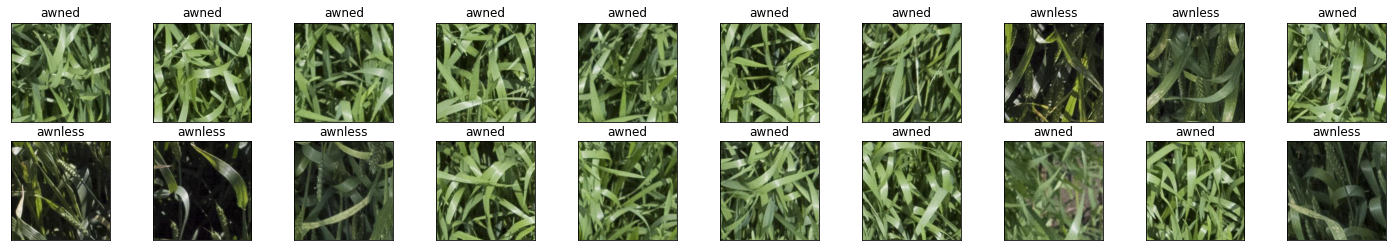

In [37]:
#plot a subset of the dataloader
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(tensor_to_image(images[idx]))
    ax.set_title("awned" if labels[idx].item() == 0 else "awnless")

In [40]:
len(train_dataloader)

10